# Node2vec in PyTorch Geometric on CORA dataset

## Setup

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

In [ ]:
import torch
from torch.nn import Embedding
from torch.utils.data import DataLoader
from torch_sparse import SparseTensor
import torch_cluster
from torch.ops.torch_cluster import random_walk

In [ ]:
EPS = 1e-15

In [ ]:
def maybe_num_nodes(edge_index, num_nodes=None):
    if num_nodes is not None:
        return num_nodes
    elif isinstance(edge_index, Tensor):
        return int(edge_index.max()) + 1 if edge_index.numel() > 0 else 0
    else:
        return max(edge_index.size(0), edge_index.size(1))

## Node2vec

In [ ]:
class Node2Vec(torch.nn.Module):
    r"""The Node2Vec model where random walks of
    length `walk_length` are sampled in a given graph, and node embeddings
    are learned via negative sampling optimization.

    Args:
        edge_index (LongTensor): The edge indices.
        embedding_dim (int): The size of each embedding vector.
        walk_length (int): The walk length.
        context_size (int): The actual context size which is considered for
            positive samples. This parameter increases the effective sampling
            rate by reusing samples across different source nodes.
        walks_per_node (int, optional): The number of walks to sample for each
            node. (default: :obj:`1`)
        p (float, optional): Likelihood of immediately revisiting a node in the
            walk. (default: :obj:`1`)
        q (float, optional): Control parameter to interpolate between
            breadth-first strategy and depth-first strategy (default: :obj:`1`)
        num_negative_samples (int, optional): The number of negative samples to
            use for each positive sample. (default: :obj:`1`)
        num_nodes (int, optional): The number of nodes. (default: :obj:`None`)
        sparse (bool, optional): If set to :obj:`True`, gradients w.r.t. to the
            weight matrix will be sparse. (default: :obj:`False`)
    """
    def __init__(self, edge_index, embedding_dim, walk_length, context_size,
                 walks_per_node=1, p=1, q=1, num_negative_samples=1,
                 num_nodes=None, sparse=False):
        super(Node2Vec, self).__init__()

        N = maybe_num_nodes(edge_index, num_nodes)
        row, col = edge_index
        self.adj = SparseTensor(row=row, col=col, sparse_sizes=(N, N))
        self.adj = self.adj.to('cpu')

        assert walk_length >= context_size

        self.embedding_dim = embedding_dim
        self.walk_length = walk_length - 1
        self.context_size = context_size
        self.walks_per_node = walks_per_node
        self.p = p
        self.q = q
        self.num_negative_samples = num_negative_samples

        self.embedding = Embedding(N, embedding_dim, sparse=sparse)

        self.reset_parameters()


    def reset_parameters(self):
        self.embedding.reset_parameters()


    def forward(self, batch=None):
        """Returns the embeddings for the nodes in :obj:`batch`."""
        emb = self.embedding.weight
        return emb if batch is None else emb[batch]


    def loader(self, **kwargs):
        return DataLoader(range(self.adj.sparse_size(0)),
                          collate_fn=self.sample, **kwargs)


    def pos_sample(self, batch):
        batch = batch.repeat(self.walks_per_node)
        rowptr, col, _ = self.adj.csr()
        rw = random_walk(rowptr, col, batch, self.walk_length, self.p, self.q)
        if not isinstance(rw, torch.Tensor):
            rw = rw[0]

        walks = []
        num_walks_per_rw = 1 + self.walk_length + 1 - self.context_size
        for j in range(num_walks_per_rw):
            walks.append(rw[:, j:j + self.context_size])
        return torch.cat(walks, dim=0)


    def neg_sample(self, batch):
        batch = batch.repeat(self.walks_per_node * self.num_negative_samples)

        rw = torch.randint(self.adj.sparse_size(0),
                           (batch.size(0), self.walk_length))
        rw = torch.cat([batch.view(-1, 1), rw], dim=-1)

        walks = []
        num_walks_per_rw = 1 + self.walk_length + 1 - self.context_size
        for j in range(num_walks_per_rw):
            walks.append(rw[:, j:j + self.context_size])
        return torch.cat(walks, dim=0)


    def sample(self, batch):
        if not isinstance(batch, torch.Tensor):
            batch = torch.tensor(batch)
        return self.pos_sample(batch), self.neg_sample(batch)


    def loss(self, pos_rw, neg_rw):
        r"""Computes the loss given positive and negative random walks."""

        # Positive loss.
        start, rest = pos_rw[:, 0], pos_rw[:, 1:].contiguous()

        h_start = self.embedding(start).view(pos_rw.size(0), 1,
                                             self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(pos_rw.size(0), -1,
                                                    self.embedding_dim)

        out = (h_start * h_rest).sum(dim=-1).view(-1)
        pos_loss = -torch.log(torch.sigmoid(out) + EPS).mean()

        # Negative loss.
        start, rest = neg_rw[:, 0], neg_rw[:, 1:].contiguous()

        h_start = self.embedding(start).view(neg_rw.size(0), 1,
                                             self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(neg_rw.size(0), -1,
                                                    self.embedding_dim)

        out = (h_start * h_rest).sum(dim=-1).view(-1)
        neg_loss = -torch.log(1 - torch.sigmoid(out) + EPS).mean()

        return pos_loss + neg_loss


    def test(self, train_z, train_y, test_z, test_y, solver='lbfgs',
             multi_class='auto', *args, **kwargs):
        r"""Evaluates latent space quality via a logistic regression downstream
        task."""
        from sklearn.linear_model import LogisticRegression

        clf = LogisticRegression(solver=solver, multi_class=multi_class, *args,
                                 **kwargs).fit(train_z.detach().cpu().numpy(),
                                               train_y.detach().cpu().numpy())
        return clf.score(test_z.detach().cpu().numpy(),
                         test_y.detach().cpu().numpy())


    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__,
                                   self.embedding.weight.size(0),
                                   self.embedding.weight.size(1))

## Running on CORA dataset

In [ ]:
import os.path as osp
from torch_geometric.datasets import Planetoid

dataset = 'Cora'
path = osp.join('data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                    context_size=10, walks_per_node=10,
                    num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                        z[data.test_mask], data.y[data.test_mask],
                        max_iter=150)
    return acc

for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

## Plot Embeddings

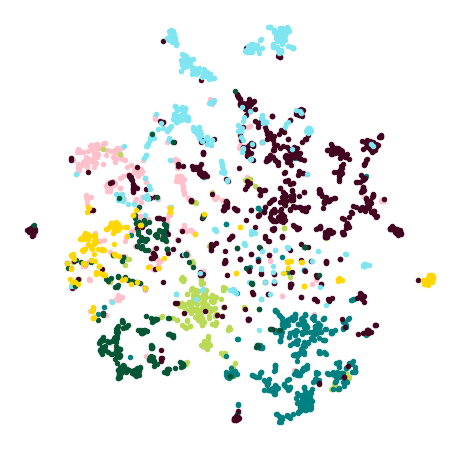

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)